# Unsupervised Learning
## Mixture of Gaussians - Numpy Implementation

Author: Bingchen Wang

Last Updated: 20 Sep, 2022

---
<nav>
    <a href="../../Machine%20Learning.ipynb">Machine Learning</a> |
    <a href="../Unsupervised Learning.ipynb">Unsupervised Learning</a> |
</nav>

---

## Content

- Import packages
- Define functions
    - initialize
    - pnorm
    - e_step
    - m_step
    - training
    - predict
    - predict_proba
    - predict_px
- Putting the algorithm into practice

### Import packages

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from sklearn.preprocessing import MinMaxScaler

### Define functions

In [157]:
# initialize
def initialize(n_components, X):
    """
    Given the number of components and the dataset, initialize the means by randomly picking examples from the dataset
    
    :param n_components: number of gaussians
    :param X: dataset ndarray (m,n)
    :return: means, variances
    """
    m,n = X.shape
    idx = np.random.permutation(m)
    phis = np.ones(n_components)*1/n_components
    means = X[idx[:3]]
    variances = [np.identity(n) for i in range(n_components)]
    return phis, means, variances

def pnorm(x, mu, Sigma):
    """
    Gives the density of x under a Gaussian with mean = mu and covariance = Sigma.
    
    :param x: ndarray (n,)
    :param mu: ndarray (n,)
    :param Sigma: ndarray (n, n)
    :return: density
    """
    n = mu.shape[0]
    density = (2*np.pi)**(-n/2)*np.linalg.det(Sigma)**(-1/2)* \
    np.exp(-1/2 * np.sum(np.matmul(x - mu, np.linalg.pinv(Sigma))* (x - mu), axis = -1))
    return density

def e_step(X, phis, means, variances):
    """
    Completes the e-step of EM.
    
    :param X: dataset ndarray (m,n)
    :param phis: ndarray (n_components,)
    :param means: ndarray (n_components,n)
    :param variances: list (n_components) with each element an ndarray (n,n)
    :return: W (m, n_components)
    """
    n_components = phis.shape[0]
    m, n = X.shape
    W = np.zeros((m, n_components))
    
    for i in range(n_components):
        phi = phis[i]
        mean = means[i]
        variance = variances[i]
        W[:,i] = pnorm(X, mean, variance)*phi
    
    W = W/np.sum(W, axis = -1, keepdims = True)
    
    return W

def m_step(X, W):
    """
    Completes the m-step of EM.
    
    :param X: dataset ndarray (m,n)
    :param W: Q(z = j) ndarray (m,n_components)
    :return: phis, means, variances
    """
    m, n = X.shape
    W_colsum = np.sum(W, axis = 0)
    phis = 1/m*W_colsum
    means = np.matmul(np.transpose(W), X)/W_colsum.reshape(-1,1)
    X_scaled = (X - means[:,np.newaxis,:]) * (np.transpose(W)[:,:,np.newaxis])**(0.5)
    variances = (np.matmul(np.transpose(X_scaled, (0,2,1)), X_scaled))/W_colsum.reshape(-1,1,1)
    
    return phis, means, variances

def training(X, n_components, num_iter = 100):
    phis, means, variances = initialize(n_components, X)
    for i in range(num_iter):
        W = e_step(X, phis, means, variances)
        phis, means, variances = m_step(X, W)
        print(f"\rIteration: {i+1}/{num_iter}", end = "")
    return phis, means, variances

def predict_proba(X, phis, means, variances):
    density = e_step(X, phis, means, variances)
    return density

def predict(X, phis, means, variances):
    density = e_step(X, phis, means, variances)
    label = np.argmax(density, axis = -1)
    return label

def predict_px(X, phis, means, variances):
    n_components = phis.shape[0]
    m, n = X.shape
    W = np.zeros((m, n_components))
    
    for i in range(n_components):
        phi = phis[i]
        mean = means[i]
        variance = variances[i]
        W[:,i] = pnorm(X, mean, variance)*phi
    
    px = np.sum(W, axis = -1)
    return px

In [177]:
# for debugging

def e_step_except(X, phis, means, variances):
    """
    Completes the e-step of EM.
    
    :param X: dataset ndarray (m,n)
    :param phis: ndarray (n_components,)
    :param means: ndarray (n_components,n)
    :param variances: list (n_components) with each element an ndarray (n,n)
    :return: W (m, n_components), variances
    """
    n_components = phis.shape[0]
    m, n = X.shape
    W = np.zeros((m, n_components))
    
    for i in range(n_components):
        phi = phis[i]
        mean = means[i]
        variance = variances[i]
        try:
            W[:,i] = pnorm(X, mean, variance)*phi
        except:
            print(f'variance before remedy: {variance}')
            variance = 1/2 * (variance + np.identity(n))
            print(f'variance after remedy: {variance}')
            W[:,i] = pnorm(X, mean, variance)*phi
            variances[i] = variance
    
    W = W/np.sum(W, axis = -1, keepdims = True)
    
    return W, variances

def training_except(X, n_components, num_iter = 100):
    phis, means, variances = initialize(n_components, X)
    for i in range(num_iter):
        try:
            W = e_step(X, phis, means, variances)
            phis, means, variances = m_step(X, W)
            print(f"\rIteration: {i+1}/{num_iter}", end = "")
            print(f"{np.round(variances, 3)}")
        except:
            W, variances = e_step_except(X, phis, means, variances)
            phis, means, variances = m_step(X, W)
            print(f"{np.round(variances, 3)}")
            print(f"\rIteration: {i+1}/{num_iter}; variance remedy has been applied.")
    return phis, means, variances

In [176]:
X = np.random.randn(20,3)

phis, means, variances = training(X, 3)
print(phis)
print(means)
print(variances)

predict(X, phis, means, variances)

Iteration: 100/100[0.31019785 0.4944833  0.19531885]
[[ 0.27435257  1.15694683 -0.60371044]
 [ 0.35905928 -0.44857008  0.77024888]
 [-0.79849039 -0.89753799 -1.6151765 ]]
[[[ 0.1357526   0.20317696  0.01706712]
  [ 0.20317696  0.50731562 -0.12294247]
  [ 0.01706712 -0.12294247  0.23230373]]

 [[ 0.30599756  0.09717723  0.06011924]
  [ 0.09717723  1.23462403 -0.1174179 ]
  [ 0.06011924 -0.1174179   0.4064464 ]]

 [[ 1.04786178  0.23982055 -0.45316481]
  [ 0.23982055  0.70273917 -0.05025837]
  [-0.45316481 -0.05025837  0.65772207]]]


array([1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 2, 2, 1, 1, 2, 0, 1, 0, 0, 2])

### Putting the algorithm into practice

In [140]:
import sklearn.datasets

iris = sklearn.datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

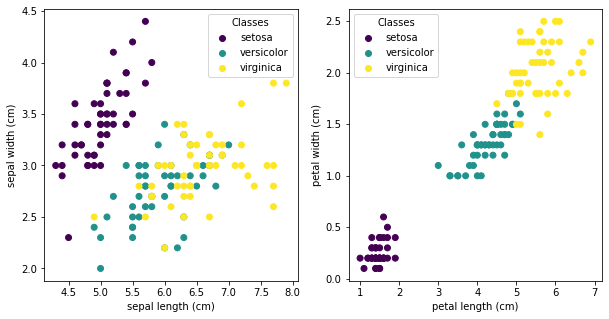

In [151]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
scatter1 = axes[0].scatter(X[:,0], X[:,1], c = y)
axes[0].set_xlabel(feature_names[0])
axes[0].set_ylabel(feature_names[1])
axes[0].legend(scatter1.legend_elements()[0], target_names, title = "Classes")
scatter2 = axes[1].scatter(X[:,2], X[:,3], c = y)
axes[1].set_xlabel(feature_names[2])
axes[1].set_ylabel(feature_names[3])
axes[1].legend(scatter2.legend_elements()[0], target_names, title = "Classes")
plt.show()

In [158]:
phis, means, variances = training(X, 3)
y_pred = predict(X, phis, means, variances)
x_prob = predict_px(X, phis, means, variances)

Iteration: 100/100

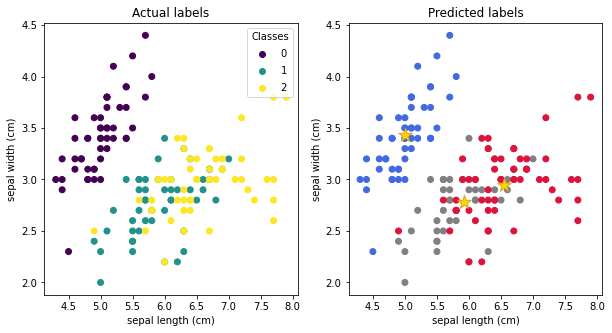

In [156]:
pred_colors = np.array(['grey', 'royalblue', 'crimson'])
fig, axes = plt.subplots(1,2, figsize = (10,5))
scatter1 = axes[0].scatter(X[:,0], X[:,1], c = y, label = target_names)
axes[0].set_xlabel(feature_names[0])
axes[0].set_ylabel(feature_names[1])
axes[0].legend(*scatter1.legend_elements(), title = "Classes")
axes[0].set_title('Actual labels')
#scatter2 = axes[1].scatter(X[:,0], X[:,1], c = pred_colors[y_pred])
axes[1].scatter(X[:,0], X[:,1], c = pred_colors[y_pred])
axes[1].set_xlabel(feature_names[0])
axes[1].set_ylabel(feature_names[1])
axes[1].scatter(means[:,0],means[:,1], c = "gold", marker = '*', s = 200, edgecolors = 'goldenrod')
axes[1].set_title('Predicted labels')
plt.show()

In [173]:
score_scaler = MinMaxScaler()
score_scaler.fit(x_prob.reshape(-1,1))
x_scaled_prob =  score_scaler.transform(x_prob.reshape(-1,1)).reshape(-1)
x_scaled_prob = 0.5*(x_scaled_prob + 0.8)

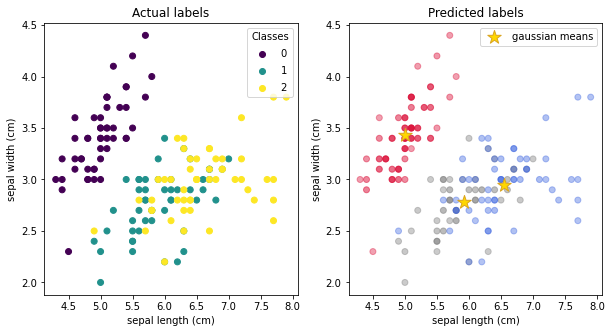

In [175]:
def alpha_scatter(ax, x, y, color_arr, alpha_arr, **kwarg):
    m = y.shape[0]
    color_rgba = [(*to_rgb(color_arr[i]),alpha_arr[i]) for i in range(m)]
    ax.scatter(x, y, c=color_rgba, **kwarg)

pred_colors = np.array(['grey', 'royalblue', 'crimson'])
fig, axes = plt.subplots(1,2, figsize = (10,5))
scatter1 = axes[0].scatter(X[:,0], X[:,1], c = y, label = target_names)
axes[0].set_xlabel(feature_names[0])
axes[0].set_ylabel(feature_names[1])
axes[0].legend(*scatter1.legend_elements(), title = "Classes")
axes[0].set_title('Actual labels')
#scatter2 = axes[1].scatter(X[:,0], X[:,1], c = pred_colors[y_pred])
alpha_scatter(axes[1], X[:,0], X[:,1], color_arr = pred_colors[y_pred], alpha_arr = x_scaled_prob)
axes[1].set_xlabel(feature_names[0])
axes[1].set_ylabel(feature_names[1])
axes[1].scatter(means[:,0],means[:,1], c = "gold", marker = '*', s = 200, edgecolors = 'goldenrod', label = "gaussian means")
axes[1].legend()
axes[1].set_title('Predicted labels')
plt.show()